<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/model%20layers%20pop/FAR-FRR_%20true%20and%20false%20verification%20-%20save%20file%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
counter true and false verification

subject number = 109 >> 90 train subject  + 19 new subject 
channel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]

model3 -  1 layer pop

'''


'\n109 subject\n1 channel (Oz)\ntask: REO \nepoch: 60\nseed = 14\n\nTrainResult ([loss , acc])= [0.12535213132612147, 0.959957998996991]\nValidationResult ([loss , acc])= [0.1946041866179451, 0.9351468373493976]\nTestResult ([loss , acc])= [0.20246034180243572, 0.9319486027944112]\n\n'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install mne

     |████████████████████████████████| 6.4MB 2.6MB/s 


In [0]:
'''
Rivision:
980806:
  First version.
  
  

'''

'\nRivision:\n980806:\n  First version.\n  \n  \n\n'

In [0]:
# Parameters:

EpochNum=60
subject_numberT=109
RemoveBaseLine=0
Orthogonal=1
task_index = [1] # task: REO
list_channel=[21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
TryStr='Try1'
seed = 14

task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =8  # outer step len
window_len= 20
batch_size=64




In [7]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import itertools
from itertools import combinations 

import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime

# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend
from keras.models import load_model



# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


Automatically created module for IPython interactive environment


In [8]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_numberT
for x in range(subject_numberT):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_numberT,task_number), dtype='object')

for i in range(subject_numberT):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


Do you want to set the path:
    /content/drive/My Drive/Deep Results/Database
as the default EEGBCI dataset path in the mne-python config [y]/n? غ
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.in

In [0]:
subject_number = 90
# new subject
new_subject =np.arange(subject_number, subject_numberT)

# img for each subject
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1
np.random.seed(seed)  

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

subject_img_number_array_shuffled=np.arange(subject_img_number)
np.random.shuffle(subject_img_number_array_shuffled)

train_index = len(subject_img_number_array_shuffled)//2
val_index = train_index + len(subject_img_number_array_shuffled)//4

train_shuff = subject_img_number_array_shuffled[:train_index]
val_shuff = subject_img_number_array_shuffled[train_index:val_index]
test_shuff = subject_img_number_array_shuffled[val_index:]


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)


In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,OrthogonalFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    #ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][0][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    e= 0    
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][0][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        
        for i in range(len(ListChannel)):
            DataChannelsRaw[e][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[e][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[e][i])) # min for each cannel

            DataChannelsNormal[e][i]=normalize_channel_data(DataChannelsRaw[e][i].copy(), i, ch_min, ch_max)
        e = e+1

        # Orthogonal Channel
        #DataChannelsOrt[e][0]=DataChannelsNormal[e][0]
        #DataChannelsOrt[e][1]=DataChannelsNormal[e][1]-ProjectionVector(DataChannelsNormal[e][0].copy(),DataChannelsNormal[e][1].copy())*OrthogonalFlag
        
        
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          r = 0
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, SampelNumberPerSec), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsNormal[r][i][0+j*OuterSampleShift + z*InnerSampleShift:SampelNumberPerSec+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data
              r=r+1

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,subject_numberT)
                TI = np.moveaxis(TrainImage, 1, -1)
                yield TI, TrainLabelClass 

                

In [0]:
ch_number=len(list_channel)
list_rawdataTemp=list_rawdata.copy()


In [0]:
#model.save('/content/drive/My Drive/mymodels/model1.h5')

In [22]:
model = load_model('/content/drive/My Drive/mymodels/model2_2.h5')
model.summary()
model.pop()
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 20, 160, 64)       11584     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 80, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 78, 128)        73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 39, 128)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 37, 256)        295168    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 18, 256)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)             

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
batch_size = 1
def subject_Predict_generator(mymodel, subject_arr, img_arr ):
  sn = len(subject_arr)
  imgn = len(img_arr)
  pre_GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled= subject_arr,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled= img_arr)

  pre_Subject = mymodel.predict_generator(pre_GenTestData,steps=np.ceil(imgn*sn/batch_size))
  return pre_Subject


In [0]:
def VerifySubject(threshold, s1, smp1, s2, smp2):
  vec1 = subject_Predict_generator(model, [s1], [smp1])
  vec2 = subject_Predict_generator(model, [s2], [smp2])
  #if comparisonType == 'same':
  if (distance.euclidean(vec1[0], vec2[0])) <threshold :
    return 0 # same
  else:
    return 1 # different


In [25]:

path = "/content/drive/My Drive/Verification Threshold"

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory /content/drive/My Drive/Verification Threshold failed


In [0]:
list_threshold = []
list_FRR = []
list_FAR = []
list_Correct_Verifi_Percentage = []

def counter_true_false_result(start_index_s1, end_index_s1 ,start_index_s2, end_index_s2 ):
  threshold = 0
  data_number = 2000

  for i in range(25,40):

    threshold = i*2
    false_rejection = 0
    false_acceptance = 0
    Correct_Verifi_Percentage = 0
    true_result= 0
    false_result = 0

    for i in range(data_number):
      
      # subject 1
      S1_rand = random.randint(start_index_s1, end_index_s1)
      S1_Sample_rand1 = random.randint(0,subject_img_number-1)
      S1_Sample_rand2 = random.randint(0,subject_img_number-1)
      while S1_Sample_rand1 == S1_Sample_rand2:
        S1_Sample_rand2 = random.randint(0,subject_img_number-1)

      result1 = VerifySubject(threshold, S1_rand, S1_Sample_rand1, S1_rand, S1_Sample_rand2)
      
      if result1 == 0:
        true_result = true_result+1
      else:
        false_result = false_result+1
        false_rejection = false_rejection +1  #FRR

      # subject 2
      S2_rand = random.randint(start_index_s2, end_index_s2)
      while S2_rand == S1_rand:
        S2_rand = random.randint(start_index_s2, end_index_s2)

      S2_Sample_rand = random.randint(0,subject_img_number-1)
      result2 = VerifySubject(threshold, S1_rand, S1_Sample_rand1, S2_rand, S2_Sample_rand)

      if result2 == 1:
        true_result = true_result+1
      else: 
        false_result = false_result+1
        false_acceptance = false_acceptance+1  #FAR
      
      #print(result1 , result2)
    Correct_Verifi_Percentage = (true_result *100) / (true_result + false_result)
    list_threshold.append(threshold)
    list_FRR.append(false_rejection)
    list_FAR.append(false_acceptance)
    list_Correct_Verifi_Percentage.append(Correct_Verifi_Percentage)
    print(threshold, '\n', Correct_Verifi_Percentage,'\n', true_result, false_result,'\n', false_rejection,false_acceptance,'\n','\n' )

  ## Save in text file
  textFileName = "threshold_S1(" + str(start_index_s1)+ "-" + str(end_index_s1) + ")_S2("+ str(start_index_s2)+ "-" + str(end_index_s2) + ")" +".txt"
  completeName = os.path.join(path, textFileName )

  with open(completeName, 'w') as f:
    f.write( 'Correct Verifi Percentage & false rejection & false acceptance: '  + '\n')
    f.writelines(str(list_threshold[j])+". " + "vrifi %: "+ str(list_Correct_Verifi_Percentage[j])+ '\t' + "FRR: " + str(list_FRR[j]) + '\t' + "FAR: " + str(list_FAR[j]) + '\n' for j in range(len(list_Correct_Verifi_Percentage)) )


50 
 100.0 
 4 0 
 0 0 
 

52 
 100.0 
 4 0 
 0 0 
 

54 
 100.0 
 4 0 
 0 0 
 

56 
 100.0 
 4 0 
 0 0 
 

58 
 75.0 
 3 1 
 1 0 
 

60 
 100.0 
 4 0 
 0 0 
 

62 
 75.0 
 3 1 
 1 0 
 

64 
 100.0 
 4 0 
 0 0 
 

66 
 75.0 
 3 1 
 1 0 
 

68 
 100.0 
 4 0 
 0 0 
 

70 
 100.0 
 4 0 
 0 0 
 

72 
 100.0 
 4 0 
 0 0 
 

74 
 100.0 
 4 0 
 0 0 
 

76 
 100.0 
 4 0 
 0 0 
 

78 
 75.0 
 3 1 
 0 1 
 



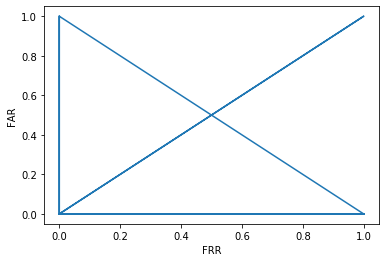

In [34]:
#1. train subject , train subject

counter_true_false_result(0,89, 0,89)
plt.plot(list_FRR, list_FAR )
plt.xlabel('FRR') 
plt.ylabel('FAR') 
#plt.legend()
plt.show()

In [0]:
#2. train subject , new subject

counter_true_false_result(0,89, 90,108)
plt.plot(list_FRR, list_FAR )
plt.xlabel('FRR') 
plt.ylabel('FAR') 
#plt.legend()
plt.show()

50 
 81.5 
 1630 370 
 357 13 
 

52 
 83.25 
 1665 335 
 319 16 
 

54 
 83.35 
 1667 333 
 310 23 
 

56 
 85.1 
 1702 298 
 258 40 
 

58 
 85.9 
 1718 282 
 232 50 
 

60 
 85.45 
 1709 291 
 226 65 
 

62 
 86.05 
 1721 279 
 195 84 
 

64 
 85.95 
 1719 281 
 187 94 
 

66 
 86.3 
 1726 274 
 161 113 
 

68 
 85.85 
 1717 283 
 152 131 
 

70 
 84.7 
 1694 306 
 141 165 
 

72 
 85.0 
 1700 300 
 131 169 
 

74 
 83.5 
 1670 330 
 120 210 
 

76 
 82.35 
 1647 353 
 117 236 
 

78 
 81.85 
 1637 363 
 101 262 
 



In [0]:
#3. new subject , new subject

counter_true_false_result(90,108, 90,108)
plt.plot(list_FRR, list_FAR )
plt.xlabel('FRR') 
plt.ylabel('FAR') 
#plt.legend()
plt.show()

50 
 77.05 
 1541 459 
 420 39 
 

52 
 77.0 
 1540 460 
 430 30 
 

54 
 78.15 
 1563 437 
 361 76 
 

56 
 78.75 
 1575 425 
 366 59 
 

58 
 78.0 
 1560 440 
 348 92 
 

60 
 78.9 
 1578 422 
 313 109 
 

62 
 77.35 
 1547 453 
 312 141 
 

64 
 76.8 
 1536 464 
 272 192 
 

66 
 76.3 
 1526 474 
 260 214 
 

68 
 76.9 
 1538 462 
 222 240 
 

70 
 76.2 
 1524 476 
 194 282 
 

72 
 75.2 
 1504 496 
 187 309 
 

74 
 73.0 
 1460 540 
 196 344 
 

76 
 72.4 
 1448 552 
 159 393 
 

78 
 70.65 
 1413 587 
 157 430 
 



In [0]:
counter_true_false_result(0,108, 0,108)

50 
 81.45 
 1629 371 
 359 12 
 

52 
 82.6 
 1652 348 
 334 14 
 

54 
 83.2 
 1664 336 
 321 15 
 

56 
 84.25 
 1685 315 
 300 15 
 

58 
 85.4 
 1708 292 
 266 26 
 

60 
 85.75 
 1715 285 
 240 45 
 

62 
 87.65 
 1753 247 
 202 45 
 

64 
 86.75 
 1735 265 
 210 55 
 

66 
 87.0 
 1740 260 
 185 75 
 

68 
 86.95 
 1739 261 
 167 94 
 

70 
 86.45 
 1729 271 
 159 112 
 

72 
 85.5 
 1710 290 
 140 150 
 

74 
 86.05 
 1721 279 
 130 149 
 

76 
 85.05 
 1701 299 
 121 178 
 

78 
 84.3 
 1686 314 
 103 211 
 

